# Analyzing Ford GoBike Data
## by Dibyashree Dikshit

## Investigation Overview

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. This data includes user information like gender, age and trip information like start time, end time, day of the week, time, duration, start station, end station, etc.

> The dataset includes bike data for Oakland and San Diego as well, but for the sake of clarity and accuracy we will just consider the bike rides taken in San Francisco.

> Since the data is spread over three years, we can find the growth of Go-Bikes over the years and also answer questions about user behavior such as - which age groups are the most active ? What time of the day are the most bikes in use? Which docks are the most popular? How well is the Bike Share for All program doing? Lets's start analyzing and see if we can answer all these questions.

## Dataset Overview

> The data consists of information regarding 3.31 million bike hiring, including age, timeframe, gender, station, and others. The dataset can be found in Ford GoBike website.
Dataset: (https://s3.amazonaws.com/fordgobike-data/index.html)
The data consisted of 16 different variables such as age, gender, weekday, time and others. It contains 3.31 million rides. Ages in dataset from 18 to 56 takes 95% of the users in dataset. So we will remove users more than 70 years old. There were users more than 100 years old, which is mainli because the app does not put restrictions on the age that can be entered through it. We will analyze the bike data for only San Francisco to account for clarity.


In [24]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
%matplotlib inline
import calendar


from IPython.display import Image

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure
from bokeh.plotting import figure, output_notebook, show 
# For showing the plots in the notebook
output_notebook()

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12.5,9.7)})

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

Loading BokehJS ...

In [25]:
# load in the dataset into a pandas dataframe

%time

df1 = pd.read_csv('201801-fordgobike-tripdata.csv')
df2 = pd.read_csv('201802-fordgobike-tripdata.csv')
df3 = pd.read_csv('201803-fordgobike-tripdata.csv')
df4 = pd.read_csv('201804-fordgobike-tripdata.csv')
df5 = pd.read_csv('201805-fordgobike-tripdata.csv')
df6 = pd.read_csv('201806-fordgobike-tripdata.csv')
df7 = pd.read_csv('201807-fordgobike-tripdata.csv')
df8 = pd.read_csv('201808-fordgobike-tripdata.csv')
df9 = pd.read_csv('201809-fordgobike-tripdata.csv')
df10 = pd.read_csv('201810-fordgobike-tripdata.csv')
df11 = pd.read_csv('201811-fordgobike-tripdata.csv')
df12 = pd.read_csv('201812-fordgobike-tripdata.csv')
df13 = pd.read_csv('2017-fordgobike-tripdata.csv')
df14 = pd.read_csv('201901-fordgobike-tripdata.csv')


CPU times: user 11 µs, sys: 6 µs, total: 17 µs
Wall time: 1.38 ms


In [26]:
data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14])

In [27]:
data = data[data.member_gender.isin(['Male', 'Female'])]
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data = data.sort_values(by = 'start_time')

In [28]:
data['duration_sec'] = data['duration_sec'] /60
data.rename(columns = {'duration_sec': 'duration_min'}, inplace=True)

In [29]:
from math import sin, cos, sqrt, atan2, radians

# We will take points in [lon,lat] form and return the distance in km between them.
def distance(point1, point2):
# approximate radius of earth in km
    R = 6373.0

    lon1 = radians(abs(point1[0]))
    lat1 = radians(abs(point1[1]))
    lon2 = radians(abs(point2[0]))
    lat2 = radians(abs(point2[1]))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [30]:
data['distance_km'] = data.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
data['distance_miles']  = data['distance_km']*0.621371

In [31]:
data.to_csv('data.csv')

In [32]:
sns.set_style('whitegrid')
sns.set_context("talk")

In [33]:
data['member_age'] = 2018-data['member_birth_year']
data['member_age'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .75, .8, .9, .95])

count    2.351591e+06
mean     3.532281e+01
std      1.046017e+01
min      1.700000e+01
10%      2.400000e+01
20%      2.700000e+01
30%      2.900000e+01
40%      3.100000e+01
50%      3.300000e+01
60%      3.500000e+01
70%      3.900000e+01
75%      4.100000e+01
80%      4.300000e+01
90%      5.000000e+01
95%      5.600000e+01
max      1.370000e+02
Name: member_age, dtype: float64

In [34]:
data = data[data['member_age']<=70]


In [35]:
max_longitude_sf = -122.3597
min_longitude_sf = -122.5147
max_latitude_sf = 37.8121
min_latitude_sf = 37.7092

In [36]:
end_station_latitude_mask = (data['end_station_latitude']>=min_latitude_sf) & (data['end_station_latitude']<=max_latitude_sf)
start_station_latitude_mask = (data['start_station_latitude']>=min_latitude_sf) & (data['start_station_latitude']<=max_latitude_sf)

In [37]:
end_station_longitude_mask =(data['end_station_longitude']>=min_longitude_sf) & (data['end_station_longitude']<=max_longitude_sf)
start_station_longitude_mask = (data['start_station_longitude']>=min_longitude_sf) & (data['start_station_longitude']<=max_longitude_sf)

In [38]:
data = data[end_station_latitude_mask & start_station_latitude_mask & end_station_longitude_mask & start_station_longitude_mask]

In [39]:
data['start_time']=pd.to_datetime(data['start_time'])
data['end_time']=pd.to_datetime(data['end_time'])

data['start_time_date']=data['start_time'].dt.date
data['end_time_date']=data['end_time'].dt.date

data['start_time_year_month']=data['start_time'].map(lambda x: x.strftime('%Y-%m'))
data['end_time_year_month']=data['end_time'].map(lambda x: x.strftime('%Y-%m'))
data['start_time_year_month_new'] = data['start_time'].dt.strftime('%y' + '-' + '%m')

data['start_time_year']=data['start_time'].dt.year.astype(int)
data['end_time_year']=data['end_time'].dt.year.astype(int)

data['start_time_month']=data['start_time'].dt.month.astype(int)
data['end_time_month']=data['end_time'].dt.month.astype(int)

data['start_time_hour_minute']=data['start_time'].map(lambda x: x.strftime('%H-%m'))
data['end_time_hour_minute']=data['end_time'].map(lambda x: x.strftime('%H-%m'))

In [40]:
data['start_time_hour']=data['start_time'].dt.hour
data['end_time_hour']=data['end_time'].dt.hour

In [41]:
data['start_time_weekday']=data['start_time'].dt.weekday_name
data['end_time_weekday']=data['end_time'].dt.weekday_name

In [42]:
data['member_age_bins'] = data['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60 - 70' if 60<x<=70
                                                  else x)

In [43]:
data['start_time_weekday_abbr']=data['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
data['end_time_weekday_abbr']=data['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [44]:
color_palette = ['yellow','orange', 'lightgreen', 'green', 'darkgreen']

In [45]:
user_type_count_per_year = data.groupby(["start_time_year_month_new", "user_type"]).size().reset_index()

In [47]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Difference in behavior between subscribers and customers

> As we can see from the figure below, the bulk of the rides is dominated by the subscribers, almost five times the rate of customers. The customers bike riding rate is increasing, but not as rapidly as the rate of subscribers. Since so much of the market is captured by the subscribers, Ford Go Bike should look into rewarding subscribers and should look into targeting returning customers and focus on converting them to subscribers.



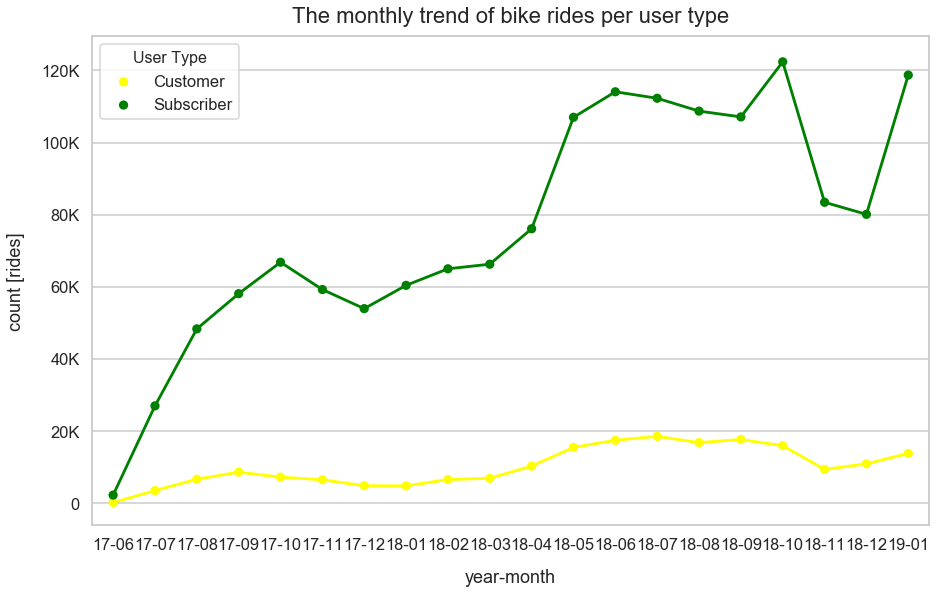

In [49]:
plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'green', 'Customer':'yellow'}
ax = sns.pointplot(x='start_time_year_month_new', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_type_count_per_year)
plt.title('The monthly trend of bike rides per user type', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image01.png');

## Is there seasonality?

> How do the seasons affect the bike rides?

As we can see that the usage during the winter months is lower compared to the summer and fall months. But the usage during winter 2018 is greater than winter 2017. This can be attributed to the fact that the user base increased by winter of 2018 and more users compared to the previous year were using the bikes.

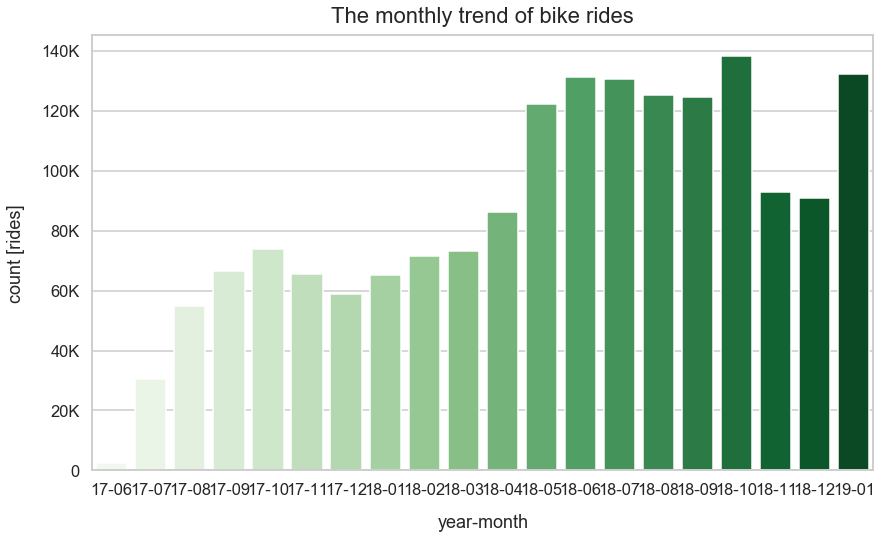

In [50]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_year_month_new', palette="Greens", data=data.sort_values(by='start_time_year_month_new'))
plt.title('The monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image03.png');

## What age groups are the most active bike riders?



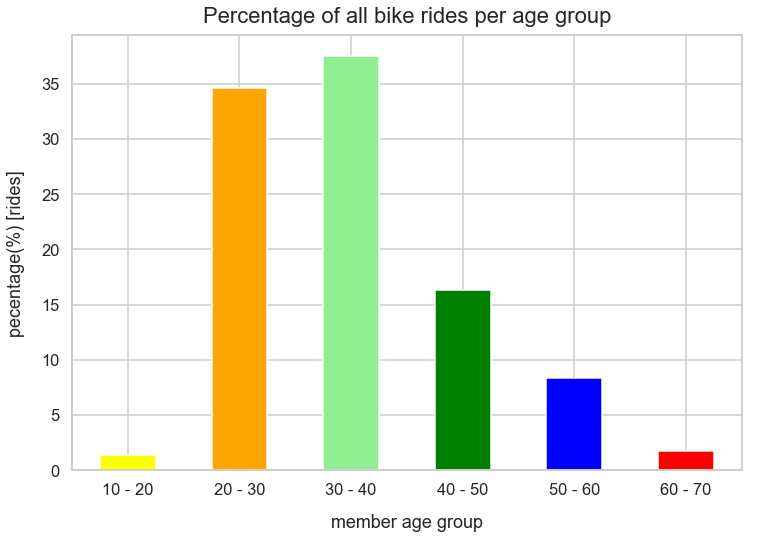

In [51]:
data_trip_by_age = data.groupby('member_age_bins').agg({'bike_id':'count'})
data_trip_by_age['perc'] = (data_trip_by_age['bike_id']/data_trip_by_age['bike_id'].sum())*100

color_palette = ['yellow', 'orange', 'lightgreen', 'green', 'blue', 'red']
data_trip_by_age['perc'].plot(kind='bar', color=color_palette, figsize=(12,8))
plt.title('Percentage of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image05.png');

As we had seen with the time of the day usage, we can conclude that most of the bikes are used for commuting for work, so its no surprise that the weekdays show the most usage. This provides valuable information regarding Ford GoBike's user base. The user base consists mostly of subscribers who are most likely to be men in the age group of 20-40 using these bikes to commute to and from work on weekdays.